In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import glob
from datetime import datetime
%matplotlib inline

Using TensorFlow backend.
C:\Users\acer\anaconda31\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acer\anaconda31\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acer\anaconda31\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\acer\anaconda31\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
dataframe = pd.read_excel(r'C:\Users\acer\Desktop\Wind.xlsx',index_col="DateTime")
dataframe.head()

,Air temperature | ('C),Pressure | (atm),Wind speed | (m/s),Wind direction | (deg),Power generated by system | (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [3]:
dataframe['Power generated by system | (kW)'].replace(0, np.nan, inplace=True)
dataframe['Power generated by system | (kW)'].fillna(method='ffill', inplace=True)

In [4]:
dataset = dataframe.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

36792 15768


In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    print(dataX)
    print(dataY)
    return np.array(dataX), np.array(dataY)

In [6]:
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

36788
[array([10.926,  9.919,  8.567,  7.877]), array([9.919, 8.567, 7.877, 7.259]), array([8.567, 7.877, 7.259, 6.57 ]), array([7.877, 7.259, 6.57 , 5.897]), array([7.259, 6.57 , 5.897, 5.109]), array([6.57 , 5.897, 5.109, 4.413]), array([5.897, 5.109, 4.413, 3.754]), array([5.109, 4.413, 3.754, 3.169]), array([4.413, 3.754, 3.169, 2.637]), array([3.754, 3.169, 2.637, 1.948]), array([3.169, 2.637, 1.948, 2.296]), array([2.637, 1.948, 2.296, 4.042]), array([1.948, 2.296, 4.042, 5.504]), array([2.296, 4.042, 5.504, 6.217]), array([4.042, 5.504, 6.217, 6.74 ]), array([5.504, 6.217, 6.74 , 7.25 ]), array([6.217, 6.74 , 7.25 , 7.579]), array([6.74 , 7.25 , 7.579, 7.612]), array([7.25 , 7.579, 7.612, 7.139]), array([7.579, 7.612, 7.139, 5.44 ]), array([7.612, 7.139, 5.44 , 4.506]), array([7.139, 5.44 , 4.506, 3.621]), array([5.44 , 4.506, 3.621, 2.707]), array([4.506, 3.621, 2.707, 2.043]), array([3.621, 2.707, 2.043, 1.268]), array([2.707, 2.043, 1.268, 0.357]), array([ 2.043,  1.268,  0.3

[array([18.83 , 17.689, 16.54 , 16.316]), array([17.689, 16.54 , 16.316, 15.882]), array([16.54 , 16.316, 15.882, 15.291]), array([16.316, 15.882, 15.291, 14.685]), array([15.882, 15.291, 14.685, 15.41 ]), array([15.291, 14.685, 15.41 , 15.094]), array([14.685, 15.41 , 15.094, 14.309]), array([15.41 , 15.094, 14.309, 14.835]), array([15.094, 14.309, 14.835, 15.358]), array([14.309, 14.835, 15.358, 15.495]), array([14.835, 15.358, 15.495, 15.96 ]), array([15.358, 15.495, 15.96 , 16.545]), array([15.495, 15.96 , 16.545, 17.58 ]), array([15.96 , 16.545, 17.58 , 18.933]), array([16.545, 17.58 , 18.933, 21.621]), array([17.58 , 18.933, 21.621, 23.884]), array([18.933, 21.621, 23.884, 25.22 ]), array([21.621, 23.884, 25.22 , 25.788]), array([23.884, 25.22 , 25.788, 25.951]), array([25.22 , 25.788, 25.951, 25.453]), array([25.788, 25.951, 25.453, 22.176]), array([25.951, 25.453, 22.176, 20.267]), array([25.453, 22.176, 20.267, 19.338]), array([22.176, 20.267, 19.338, 18.366]), array([20.267, 

In [7]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save("mymodel.h5")

In [9]:
yhat = model.predict(testX)
testX

array([[[18.83 , 17.689, 16.54 , 16.316]],

       [[17.689, 16.54 , 16.316, 15.882]],

       [[16.54 , 16.316, 15.882, 15.291]],

       ...,

       [[ 1.407,  2.526,  3.306,  3.674]],

       [[ 2.526,  3.306,  3.674,  3.015]],

       [[ 3.306,  3.674,  3.015, -0.317]]])

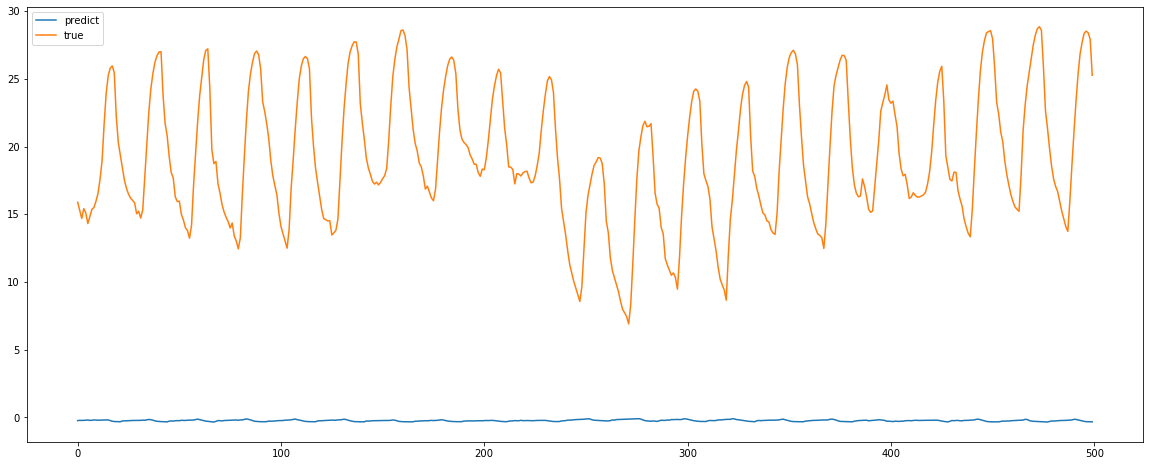

In [10]:
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()

In [11]:
print("Mean squared error: %.3f" % mean_squared_error(testY, yhat))

Mean squared error: 382.428


In [12]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat)))

Root mean squared error: 19.556


In [13]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))

Variance : -3.848


In [14]:
from sklearn.metrics import mean_absolute_error
print("Mean absolute error: %.3f" % mean_absolute_error(testY, yhat))

Mean absolute error: 17.543
